In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from torch.utils.data import DataLoader
from torchvision import transforms

# === Import your specific classes ===
# Ensure VAE.py and ISICDataset.py are in the same folder as this notebook
from VAE import HairRemovalVAE
from ISICDataset import ISICDataset

# Enable inline plotting for Jupyter
%matplotlib inline

In [6]:
# ====== CONFIGURATION ======
# UPDATE THIS PATH to point to your specific checkpoint
MODEL_CHECKPOINT_PATH = "./VAE_checkpoints/12082025_test_loss_vae(0.5)_ssim(0.5)_epoch_30.pth"

SPLITS_PATH = 'splits.json'
IMG_SIZE = (256, 256)
NUM_PAIRS_TO_SHOW = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running on device: {DEVICE}")

Running on device: cpu


In [7]:
def tensor_to_numpy_img(tensor):
    """
    Prepares a PyTorch tensor for Matplotlib visualization.
    Assumes model output is Sigmoid (range 0 to 1).
    """
    # 1. Move to CPU, detach from gradients, clone to avoid modifying original
    img = tensor.cpu().detach().clone()
    
    # img is currently (C, H, W) -> Matplotlib needs (H, W, C)
    img = img.permute(1, 2, 0)
    
    # Convert to numpy
    img = img.numpy()
    
    # Ensure values are clipped between 0 and 1 just in case
    #img = np.clip(img, 0, 1)
    return img

def load_model(checkpoint_path, device):
    """Instantiates model and loads weights from checkpoint."""
    print(f"Loading model from: {checkpoint_path}")
    model = HairRemovalVAE().to(device)
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
        
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Handle different ways checkpoints might be saved
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.eval() 
    return model

def get_validation_sample(splits_path, img_size, num_samples):
    """Loads a small batch from the validation set."""
    with open(splits_path, 'rb') as f:
        splits = json.load(f)
    val_list = splits['validation_set']

    val_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])

    # Using validation set to see unseen data
    val_dataset = ISICDataset(val_list, transform=val_transform)
    loader = DataLoader(val_dataset, batch_size=num_samples, shuffle=True)
    
    # Grab first batch
    originals, _ = next(iter(loader))
    return originals

Loading model from: ./VAE_checkpoints/12082025_test_loss_vae(0.5)_ssim(0.5)_epoch_30.pth


/var/folders/dn/bfmmyy6d3wn_kn41x0_rq1jc0000gn/T/ipykernel_99289/65766897.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

Plotting results...


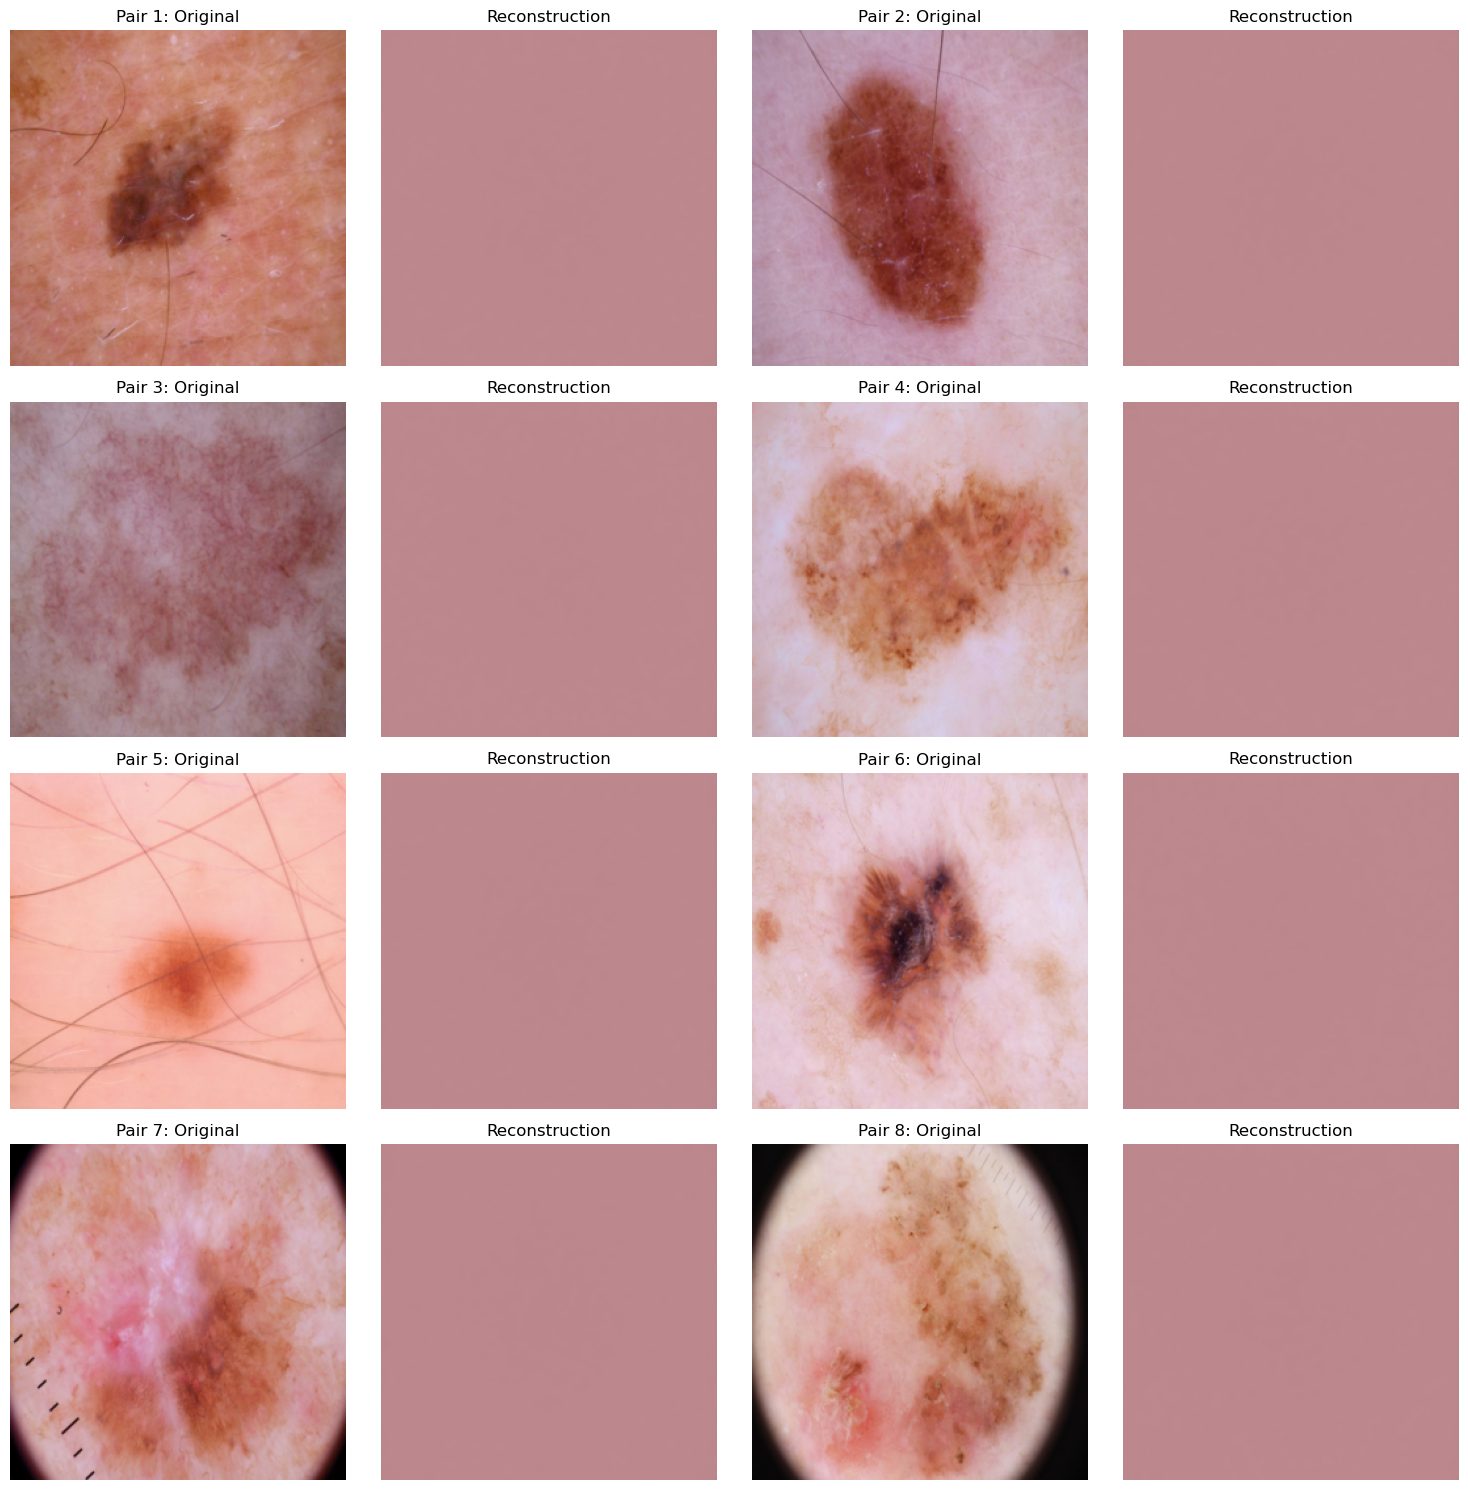

In [8]:
# Load Model
try:
    vae_model = load_model(MODEL_CHECKPOINT_PATH, DEVICE)
    
    # Get Data
    input_images = get_validation_sample(SPLITS_PATH, IMG_SIZE, NUM_PAIRS_TO_SHOW)
    
    # Run Inference
    input_images = input_images.to(DEVICE)
    with torch.no_grad():
        reconstructions, _, _ = vae_model(input_images)
    
    # Plot
    print("Plotting results...")
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(NUM_PAIRS_TO_SHOW):
        ax_orig_idx = i * 2
        ax_recon_idx = i * 2 + 1
        
        img_orig_np = tensor_to_numpy_img(input_images[i])
        img_recon_np = tensor_to_numpy_img(reconstructions[i])

        # Original
        axes[ax_orig_idx].imshow(img_orig_np)
        axes[ax_orig_idx].set_title(f"Pair {i+1}: Original")
        axes[ax_orig_idx].axis('off')

        # Reconstruction
        axes[ax_recon_idx].imshow(img_recon_np)
        axes[ax_recon_idx].set_title(f"Reconstruction")
        axes[ax_recon_idx].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"\nERROR: {e}")
    print("Please update MODEL_CHECKPOINT_PATH in Cell 2.")
except Exception as e:
    print(f"An error occurred: {e}")

In [10]:
input_images.shape

torch.Size([8, 3, 256, 256])

In [12]:
input_images[0].shape

torch.Size([3, 256, 256])

In [14]:
test = torch.unsqueeze(input_images[0], dim=0)

In [15]:
test.shape

torch.Size([1, 3, 256, 256])

In [36]:
from SSIM import ssim

mu, sigma = 1.5, 1.1
gaussian_noise = torch.randn_like(test) * sigma + mu
noisy_img = test + gaussian_noise

index = ssim(test, noisy_img, 3)

In [41]:
test.shape

torch.Size([1, 3, 256, 256])

In [42]:
mask = torch.tensor([0, 0, 1], dtype=test.dtype, device=test.device)
mask = mask.view(1, 3, 1, 1)         # reshape to broadcast over H, W

In [49]:
masked_noise = gaussian_noise * mask
masked_noise_np = torch.squeeze(masked_noise, dim=0)
masked_test = test + masked_noise

In [55]:
index=ssim(test, masked_test, 11, 1.5)

In [56]:
print(index)

tensor(0.6679)


In [51]:
test_img = torch.squeeze(test, dim=0)
noisy_np = torch.squeeze(noisy_img, dim=0)
masked_test_np = torch.squeeze(masked_test, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.108821..7.382446].


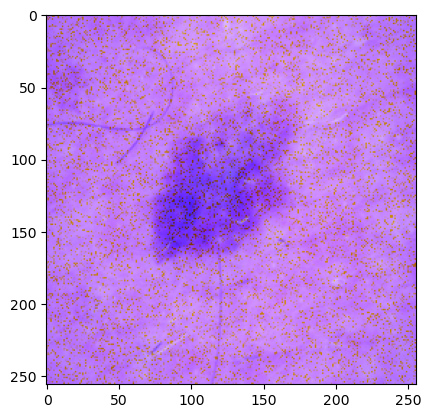

In [52]:
plt.imshow((masked_test_np).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.108821..7.382446].


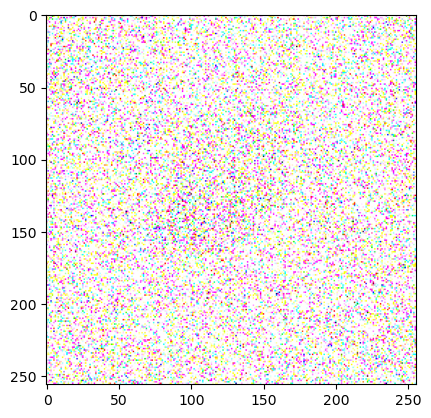

In [39]:
plt.imshow(noisy_np.permute(1,2,0))

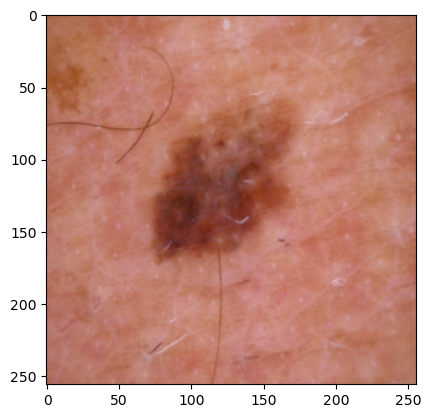

In [22]:
plt.imshow(test_img.permute(1,2,0))